In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt

In [8]:
# Load the data
file_path = r"C:\Users\Pedro\Desktop\Estágio_REN\Dados\Dados_DL1\all_variables-DL1-rp1_A1P-REF-ABS.csv"
columns = ["ABS_MU", "ABS_AM1", "ABS_AM2", "ABS_DM1"]

df = pd.read_csv(file_path)
data = df[columns].dropna().reset_index(drop=True)


🔍 Processing: ABS_MU


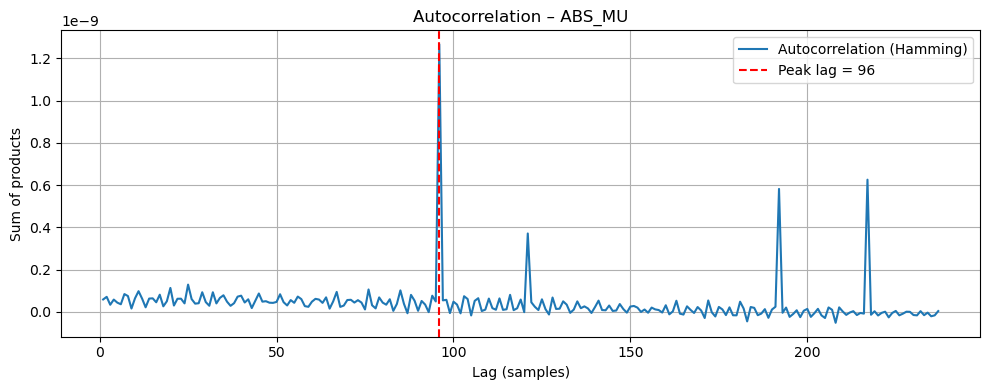

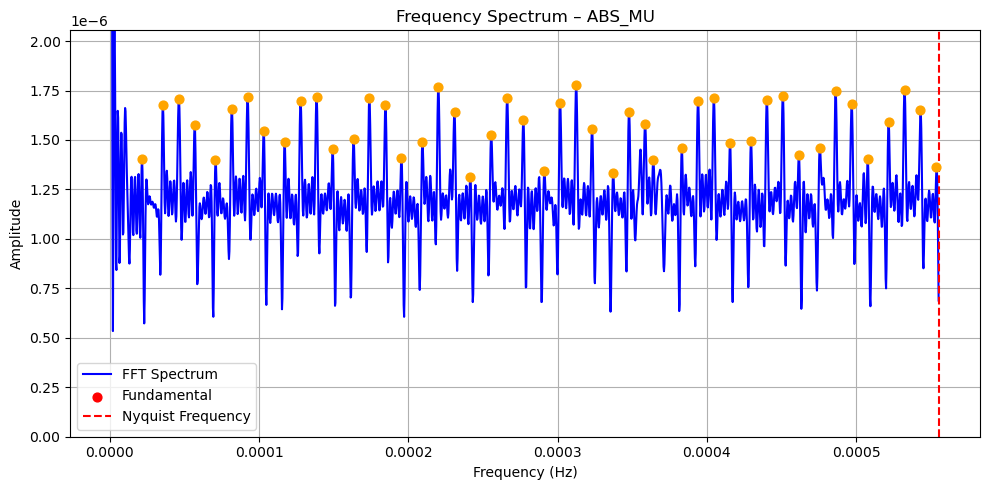


🔍 Processing: ABS_AM1


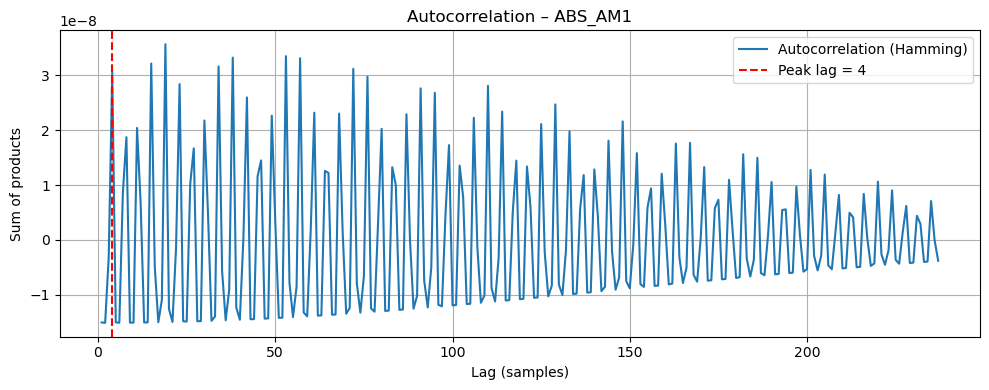

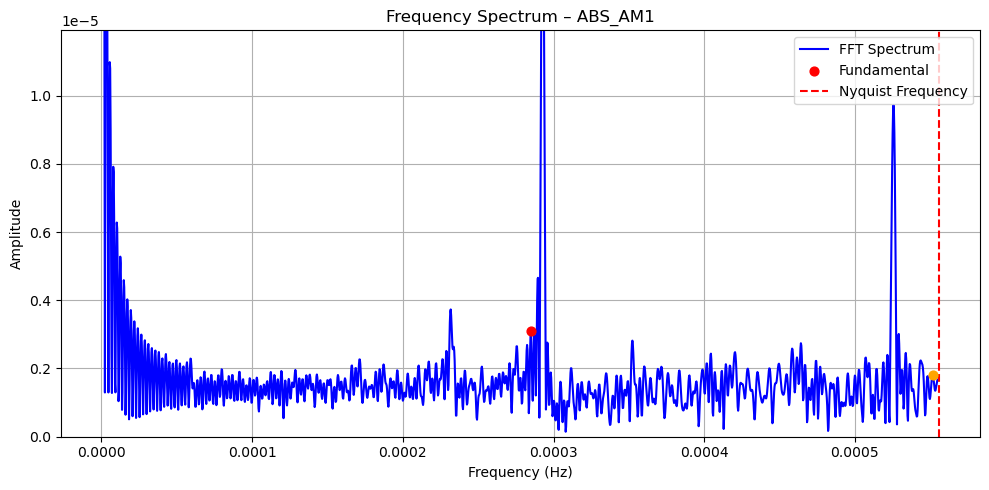


🔍 Processing: ABS_AM2


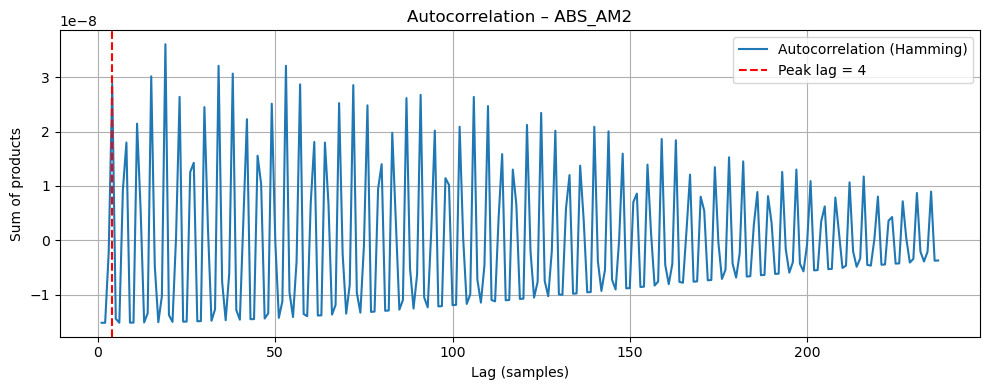

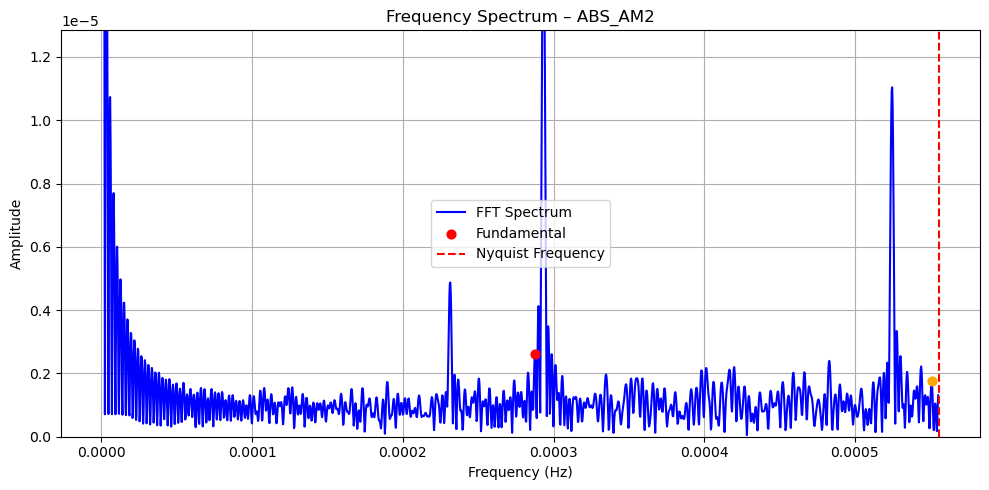


🔍 Processing: ABS_DM1


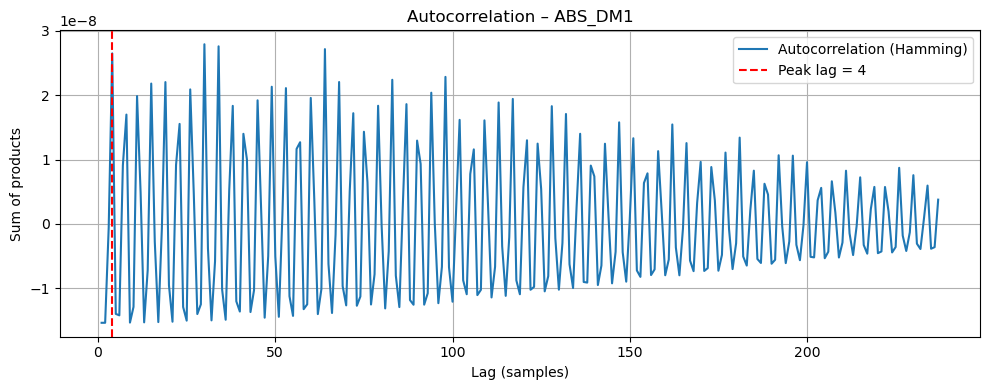

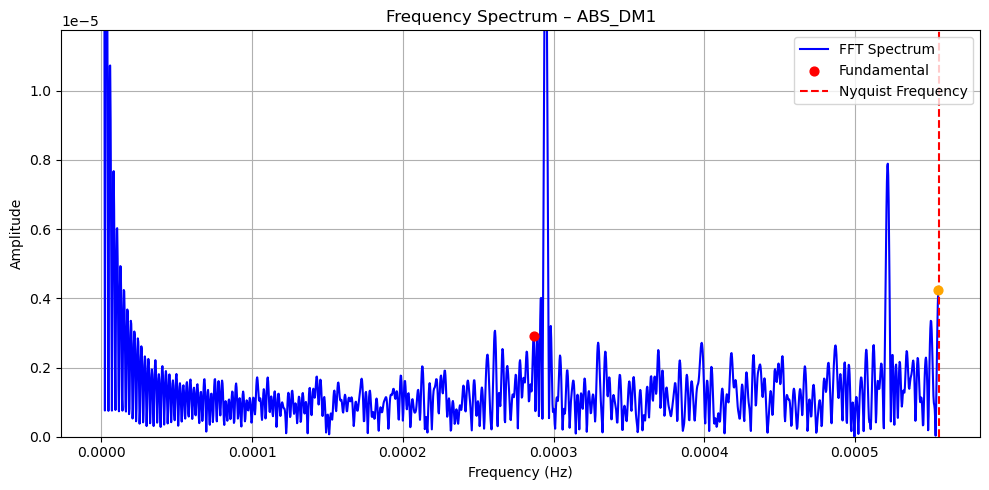


📋 Frequências fundamentais estimadas:
 - ABS_MU: 1.157407e-05 Hz
 - ABS_AM1: 2.777778e-04 Hz
 - ABS_AM2: 2.777778e-04 Hz
 - ABS_DM1: 2.777778e-04 Hz


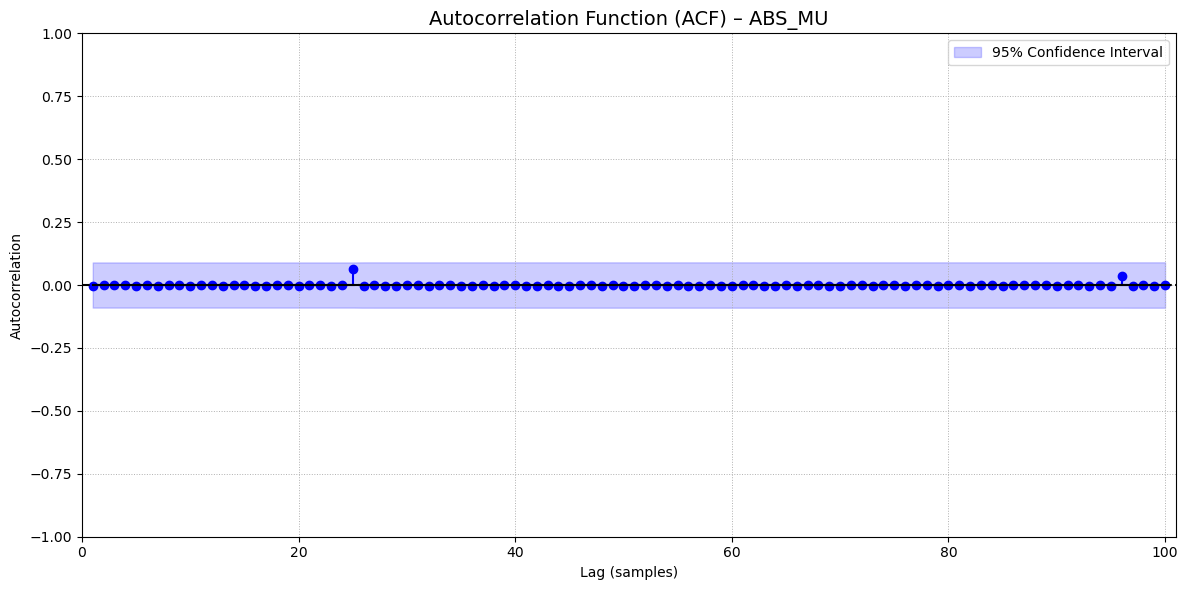

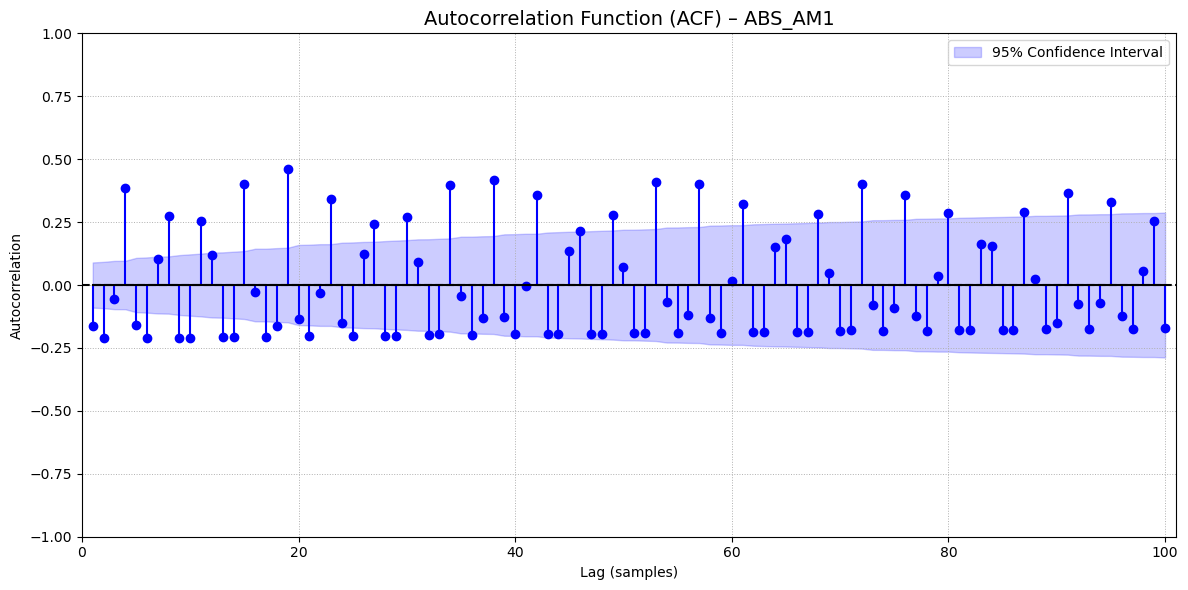

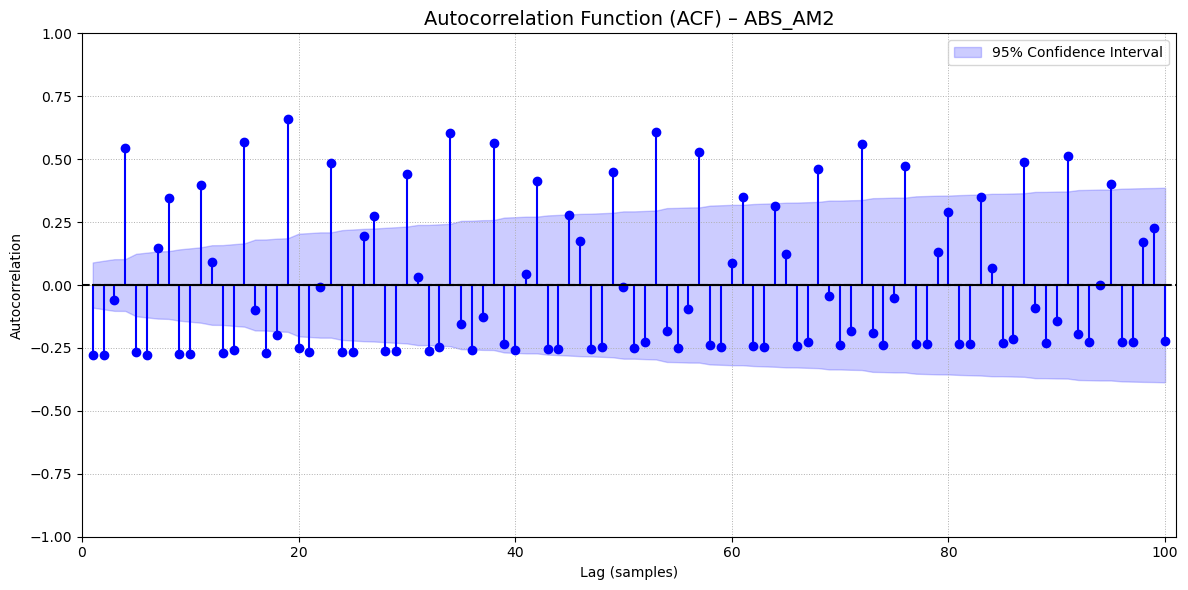

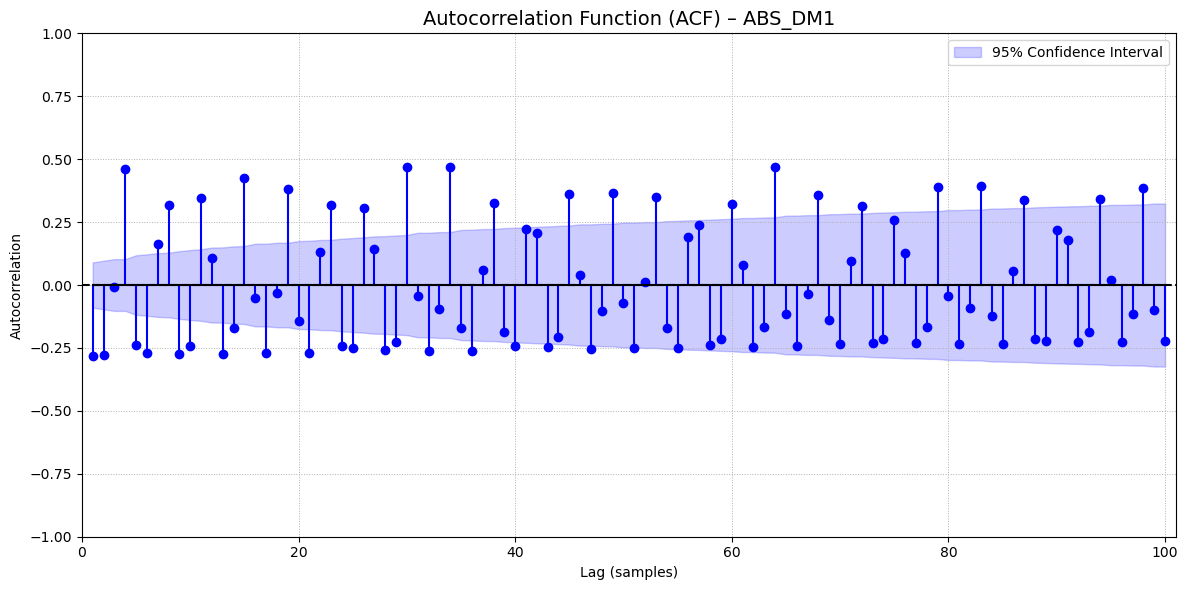

In [9]:
# === Parâmetros ===
T = 900  # 15 minutos
N = len(data)
padding_factor = 8
nyquist_freq = 1 / (2 * T)
frequencies = {}

# === Estimar f0 com autocorrelação e desenhar o gráfico ===
def estimate_fundamental_frequency(signal, label):
    N = len(signal)
    signal = signal - np.mean(signal)
    signal = signal * np.hamming(N)

    autocorr = [np.dot(signal[:-lag], signal[lag:]) for lag in range(1, N // 2)]
    autocorr = np.array(autocorr)

    peaks, _ = find_peaks(autocorr, distance=5)
    threshold = 0.5 * np.max(autocorr)

    for peak in peaks:
        if autocorr[peak] >= threshold:
            lag_peak = peak + 1
            break
    else:
        lag_peak = peaks[0] + 1

    f0 = 1 / (lag_peak * T)

    # Gráfico da autocorrelação
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(autocorr) + 1), autocorr, label="Autocorrelation (Hamming)")
    plt.axvline(x=lag_peak, color='red', linestyle='--', label=f"Peak lag = {lag_peak}")
    plt.title(f"Autocorrelation – {label}")
    plt.xlabel("Lag (samples)")
    plt.ylabel("Sum of products")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return f0

# === FFT com harmónicas ===
def plot_fft_with_harmonics(signal, label, f0):
    padded_len = padding_factor * N
    signal_padded = np.pad(signal, (0, padded_len - len(signal)), mode='constant')
    fft_result = fft(signal_padded)
    freqs = fftfreq(padded_len, T)[:padded_len // 2]
    amplitude = 2.0 / N * np.abs(fft_result[:padded_len // 2])

    spectrum = pd.DataFrame({"Frequency (Hz)": freqs, "Amplitude": amplitude})
    spectrum = spectrum[spectrum["Frequency (Hz)"] > 0]
    filtered = spectrum[spectrum["Frequency (Hz)"] <= 0.001].reset_index(drop=True)

    # Remover os 3 primeiros valores
    filtered = filtered.iloc[3:].reset_index(drop=True)

    # Harmónicas
    harmonics = []
    delta = 0.00001
    n = 1
    while f0 * n <= 0.001:
        f_h = f0 * n
        window = filtered[(filtered["Frequency (Hz)"] >= f_h - delta) &
                          (filtered["Frequency (Hz)"] <= f_h + delta)]
        if not window.empty:
            idx_peak = window["Amplitude"].idxmax()
            f_match = filtered.loc[idx_peak, "Frequency (Hz)"]
            a_match = filtered.loc[idx_peak, "Amplitude"]
            harmonics.append((f_match, a_match, n))
        n += 1

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(filtered["Frequency (Hz)"], filtered["Amplitude"], label="FFT Spectrum", color='blue')
    for f, a, n in harmonics:
        color = 'red' if n == 1 else 'orange'
        label_h = "Fundamental" if n == 1 else None
        plt.scatter(f, a, color=color, s=40, label=label_h, zorder=5)
    plt.axvline(x=nyquist_freq, color='red', linestyle='--', label="Nyquist Frequency")

    upper_limit = np.percentile(filtered["Amplitude"], 99) * 1.2
    plt.ylim(0, upper_limit)

    plt.title(f"Frequency Spectrum – {label}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === ACF ===
def plot_acf_series(df, columns, lags=100):
    for col in columns:
        fig, ax = plt.subplots(figsize=(12, 6))
        values = df[col].dropna().values
        acf_values, confint = acf(values, nlags=lags, alpha=0.05)
        ax.stem(range(1, lags + 1), acf_values[1:], linefmt='b-', markerfmt='bo', basefmt='k-')
        ax.fill_between(range(1, lags + 1),
                        confint[1:, 0] - acf_values[1:],
                        confint[1:, 1] - acf_values[1:],
                        color='blue', alpha=0.2, label="95% Confidence Interval")
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_ylim(-1, 1)
        ax.set_xlim(0, lags + 1)
        ax.set_title(f"Autocorrelation Function (ACF) – {col}", fontsize=14)
        ax.set_xlabel("Lag (samples)")
        ax.set_ylabel("Autocorrelation")
        ax.grid(True, linestyle=':', linewidth=0.7)
        ax.legend()
        plt.tight_layout()
        plt.show()

# === Execução Principal ===
for col in columns:
    signal = data[col].to_numpy()
    print(f"\n🔍 Processing: {col}")
    f0 = estimate_fundamental_frequency(signal, col)
    frequencies[col] = f0
    plot_fft_with_harmonics(signal, col, f0)

# === Resumo ===
print("\n📋 Frequências fundamentais estimadas:")
for meter, f in frequencies.items():
    print(f" - {meter}: {f:.6e} Hz")

# === ACF ===
plot_acf_series(data, columns, lags=100)